In [2]:
from time import perf_counter
import numpy as np # version = 1.24.3
import torch # version = 2.0.0 + cu118
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import ConnectionPatch
import seaborn as sns
from sklearn.datasets import make_regression
from tqdm import tqdm
from PIL import Image

(200, 1) (200,)


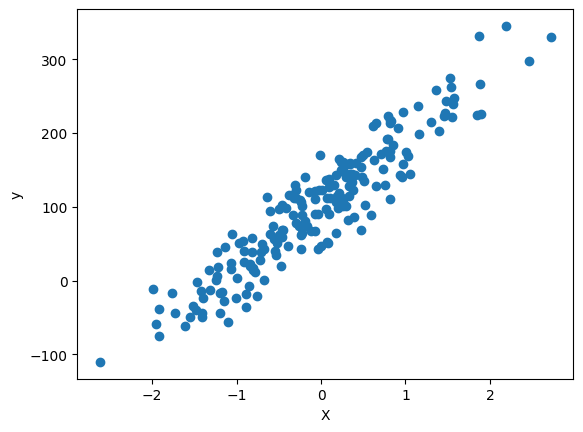

In [68]:
X, y = make_regression(n_samples=200, n_features=1, bias=100, noise=30, random_state=42)
print(X.shape, y.shape)
# plot the data
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()


[84.97339503]


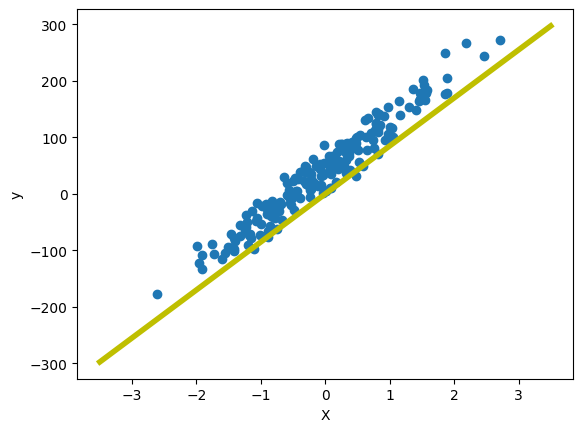

In [4]:
b = np.linalg.inv(X.T @ X) @ X.T @ y
print(b)
x_sample = np.array([-3.5, -2.0, -1.5, -1.0, 0.0, 1.0, 1.5, 2.0, 3.5])
y_line = x_sample * b

plt.plot(x_sample, y_line, linestyle="-", color="y", linewidth=4)
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

## Linear Regression using for-loop
Using numpy for loop based test
Using PyTorch for matmul (CPU, GPU)
Mean squared error
\begin{gather*}
MSE = \frac{1}{n} \sum_{i=1}^{n}(y_i - pred)^2
\end{gather*}

Converting to matrix form:
\begin{gather*}
MSE = (y - (X*m +c)) @ (y - (X.T*m +c)).T
\end{gather*}

Code partially referenced from: https://www.analyticsvidhya.com/blog/2021/06/linear-regression-in-machine-learning/

In [69]:
X.shape, y.shape
# X, y = torch.FloatTensor(X), torch.FloatTensor(y)

iterations = 100
lr = 0.0001
m = 0.0
c = 0.0
error = []
m_list = []
c_list = []

for itr in tqdm(range(iterations)):
    error_cost = 0
    cost_m = 0
    cost_c = 0
    for i in range(X.shape[0]):
        y_pred = m * X[i, 0] + c   # predict value for given x
        error_cost = error_cost + (y[i] - y_pred) ** 2
        for j in range(X.shape[0]):
            partial_wrt_c = -2 *(y[j] - (m * X[j, 0] + c))                # partial derivative w.r.t m
            partial_wrt_m = (-2 * X[j, 0]) * (y[j] - (m * X[j, 0] + c))   # partial derivative w.r.t c
            cost_m = cost_m + partial_wrt_m   # calculate cost for each number and add
            cost_c = cost_c + partial_wrt_c   # calculate cost for each number and add
    m = m - lr * cost_m/X.shape[0]    #update m
    c = c - lr * cost_c/X.shape[0]    #update c
    
    m_list.append(m)
    c_list.append(c)
    error.append(error_cost)  # Append the data in array

100%|██████████| 100/100 [00:04<00:00, 22.95it/s]


84.21814696663365 41.78578918938428 82928.11793781078


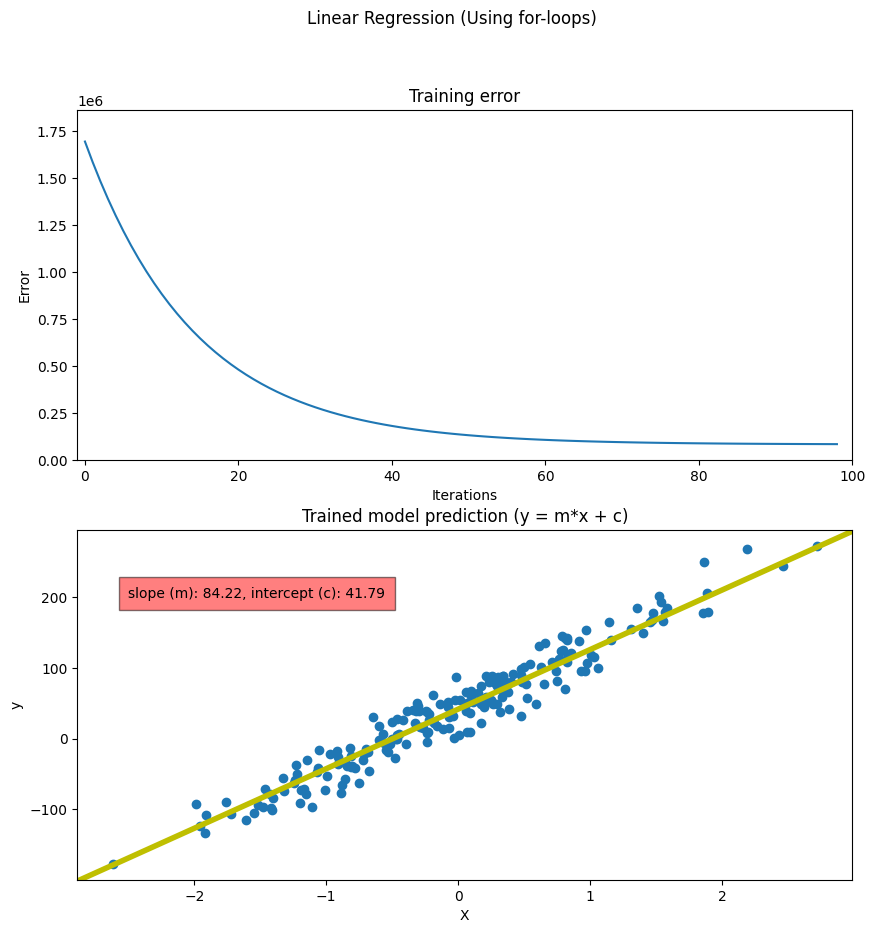

In [38]:
print(m, c, error_cost)
fig, axis = plt.subplots(2, figsize=(10, 10))

fig.suptitle("Linear Regression (Using for-loops)")
axis[0].set_title("Training error")
axis[0].set_xlabel("Iterations")
axis[0].set_ylabel("Error")
axis[0].set_ylim(0, max(error)*1.1)
axis[0].set_xlim(-1, iterations)
x_sample = np.array([-3.5, -2.0, -1.5, -1.0, 0.0, 1.0, 1.5, 2.0, 3.5])

axis[1].scatter(X, y)
axis[1].set_title("Trained model prediction (y = m*x + c)")
axis[1].set_xlabel('X')
axis[1].set_ylabel('y')

error_plot, = axis[0].plot([])
pred_line_plot, = axis[1].plot([], [], linestyle="-", color="y", linewidth=4)
pred_txt_plot = axis[1].text(-2.5, 200, '', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 7})

def animate(i):
    y_line = x_sample * m_list[i] + c_list[i]
    error_plot.set_data(range(i), error[:i])
    pred_line_plot.set_data(x_sample, y_line)
    pred_txt_plot.set_text(f"slope (m): {m_list[i]:.2f}, intercept (c): {c_list[i]:.2f}")

    return error_plot, pred_line_plot, pred_txt_plot

ani = animation.FuncAnimation(
    fig,
    animate,
    blit=False,
    frames=len(c_list),
)
with Image.new('RGB', (800, 1000), (255, 255, 255)) as bg:
    ani.save('linear_regress_forloop.gif', writer='pillow', fps=5)
plt.show()
plt.close()

## Linear Regression using Matrix Multiplication

In [73]:
X_torch, y_torch = torch.FloatTensor(X[:, 0]), torch.FloatTensor(y)
X.shape, y.shape

iterations = 100
lr = 0.0001
m = 0.0
c = 0.0
error_matmul = []
m_list_matmul = []
c_list_matmul = []

avg_iter_speed_matmul = []
for itr in tqdm(range(iterations)): 
    t_start = perf_counter()
    y_pred = m * X[:, 0] + c
    diff = y - y_pred
    error_cost = diff @ diff.T

    cost_c = np.sum(-2 * diff)
    cost_m = -2 * X[:, 0] @ diff
    
    m = m - lr * cost_m
    c = c - lr * cost_c
    t_end = perf_counter()

    if itr > 10:
        avg_iter_speed_matmul.append(t_end - t_start)

    m_list_matmul.append(m)
    c_list_matmul.append(c)
    error_matmul.append(error_cost)  # Append the data in array
avg_iter_speed_matmul = np.mean(avg_iter_speed_matmul)

m, c, error_cost

100%|██████████| 100/100 [00:00<00:00, 73186.25it/s]


(83.62137879268495, 102.1614098624382, 185467.12870993177)

84.2181469666336 41.78578918938425


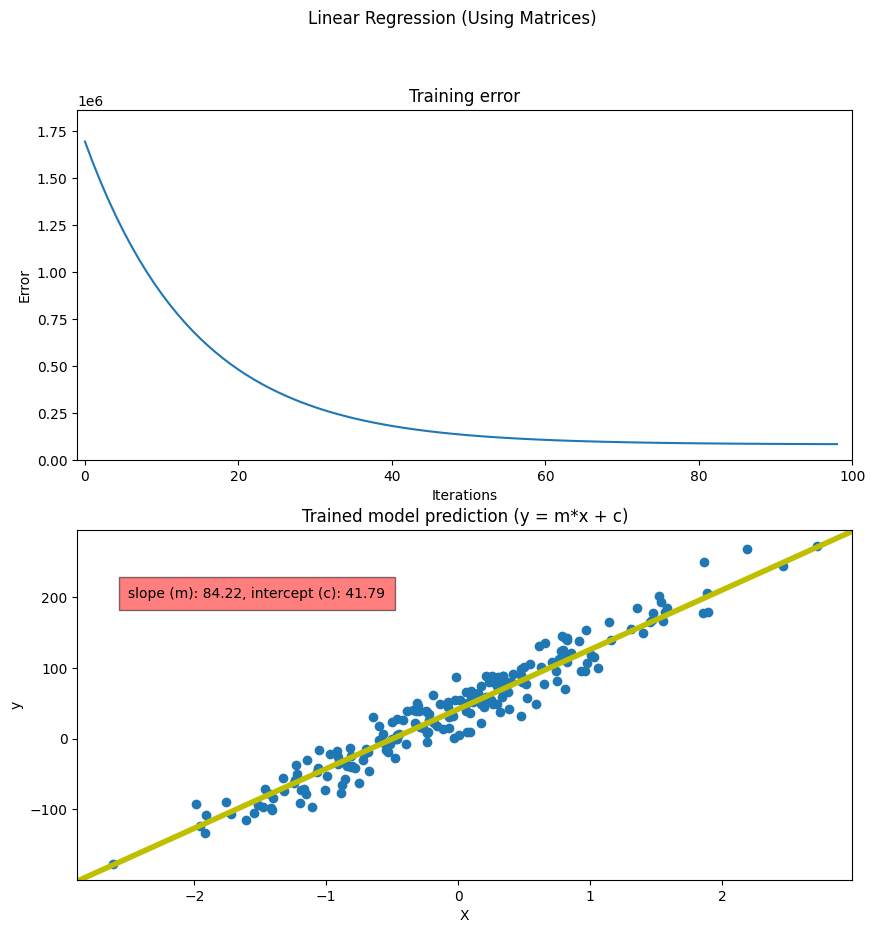

In [26]:
print(m, c)
fig, axis = plt.subplots(2, figsize=(10, 10))

fig.suptitle("Linear Regression (Using Matrices)")
axis[0].set_title("Training error")
axis[0].set_xlabel("Iterations")
axis[0].set_ylabel("Error")
axis[0].set_ylim(0, max(error_matmul)*1.1)
axis[0].set_xlim(-1, iterations)
x_sample = np.array([-3.5, -2.0, -1.5, -1.0, 0.0, 1.0, 1.5, 2.0, 3.5])

axis[1].scatter(X, y)
axis[1].set_title("Trained model prediction (y = m*x + c)")
axis[1].set_xlabel('X')
axis[1].set_ylabel('y')

error_plot, = axis[0].plot([])
pred_line_plot, = axis[1].plot([], [], linestyle="-", color="y", linewidth=4)
pred_txt_plot = axis[1].text(-2.5, 200, '', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 7})

def animate(i):
    y_line = x_sample * m_list_matmul[i] + c_list_matmul[i]
    error_plot.set_data(range(i), error_matmul[:i])
    pred_line_plot.set_data(x_sample, y_line)
    pred_txt_plot.set_text(f"slope (m): {m_list_matmul[i]:.2f}, intercept (c): {c_list_matmul[i]:.2f}")

    return error_plot, pred_line_plot, pred_txt_plot

ani = animation.FuncAnimation(
    fig,
    animate,
    blit=False,
    frames=len(c_list),
)
with Image.new('RGB', (800, 1000), (255, 255, 255)) as bg:
    ani.save('linear_regress_matrix.gif', writer='pillow', fps=5)
plt.show()

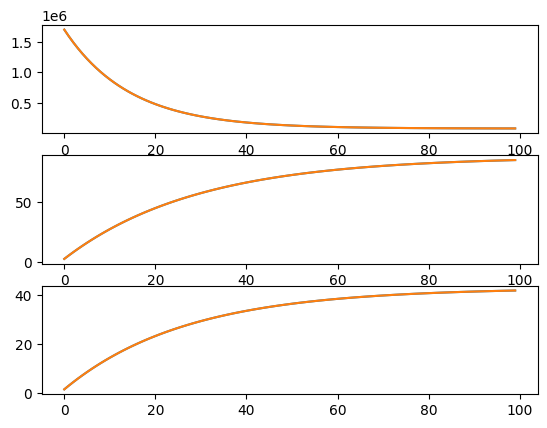

In [20]:
fig, ax = plt.subplots(3)

ax[0].plot(error)
ax[0].plot(error_matmul)
ax[1].plot(m_list)
ax[1].plot(m_list_matmul)
ax[2].plot(c_list)
ax[2].plot(c_list_matmul)

plt.show()